# Investigating Sex Signature Features

**Gregory Way, 2019**

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn import preprocessing

sys.path.append("../8.gtex-interpret")
from scripts.utils import load_weight_matrix, apply_signature

In [2]:
np.random.seed(123)

In [3]:
%matplotlib inline

## Load and Process Gene Dictionary

In [4]:
# Load curated gene names from versioned resource 
commit = '721204091a96e55de6dcad165d6d8265e67e2a48'
url = 'https://raw.githubusercontent.com/cognoma/genes/{}/data/genes.tsv'.format(commit)

gene_df = pd.read_table(url)

symbol_to_entrez = dict(zip(gene_df.symbol,
                            gene_df.entrez_gene_id))

gene_df = gene_df.dropna(axis='rows', subset=['synonyms'])
gene_df.synonyms = gene_df.synonyms.str.split('|')

all_syn = (
    gene_df.apply(lambda x: pd.Series(x.synonyms), axis=1)
    .stack()
    .reset_index(level=1, drop=True)
)

# Name the synonym series and join with rest of genes
all_syn.name = 'all_synonyms'
gene_with_syn_df = gene_df.join(all_syn)

# Remove rows that have redundant symbols in all_synonyms
gene_with_syn_df = (
    gene_with_syn_df
    
    # Drop synonyms that are duplicated - can't be sure of mapping
    .drop_duplicates(['all_synonyms'], keep=False)

    # Drop rows in which the symbol appears in the list of synonyms
    .query('symbol not in all_synonyms')
)

# Create a synonym to entrez mapping and add to dictionary
synonym_to_entrez = dict(zip(gene_with_syn_df.all_synonyms,
                             gene_with_syn_df.entrez_gene_id))

symbol_to_entrez.update(synonym_to_entrez)

# Load gene updater
url = 'https://raw.githubusercontent.com/cognoma/genes/{}/data/updater.tsv'.format(commit)
updater_df = pd.read_table(url)
old_to_new_entrez = dict(zip(updater_df.old_entrez_gene_id,
                             updater_df.new_entrez_gene_id))

gene_df.entrez_gene_id = gene_df.entrez_gene_id.astype(str)

print(gene_df.shape)
gene_df.head()

(25864, 7)


,entrez_gene_id,symbol,description,chromosome,gene_type,synonyms,aliases
0,1,A1BG,alpha-1-B glycoprotein,19,protein-coding,"[A1B, ABG, GAB, HYST2477]",alpha-1B-glycoprotein|HEL-S-163pA|epididymis s...
1,2,A2M,alpha-2-macroglobulin,12,protein-coding,"[A2MD, CPAMD5, FWP007, S863-7]",alpha-2-macroglobulin|C3 and PZP-like alpha-2-...
2,3,A2MP1,alpha-2-macroglobulin pseudogene 1,12,pseudo,[A2MP],pregnancy-zone protein pseudogene
3,9,NAT1,N-acetyltransferase 1,8,protein-coding,"[AAC1, MNAT, NAT-1, NATI]",arylamine N-acetyltransferase 1|N-acetyltransf...
4,10,NAT2,N-acetyltransferase 2,8,protein-coding,"[AAC2, NAT-2, PNAT]",arylamine N-acetyltransferase 2|N-acetyltransf...


## Load and Proces Sex Genes

Using the resource `Sex-Associated Gene Database` (SAGD) ([Shi et al. 2018](https://doi.org/10.1093/nar/gky1040))

Downloading from http://bioinfo.life.hust.edu.cn/SAGD#!/browse_gene

Selecting human species, all tissues, all stages. The downloaded file is included in this repo.

In [5]:
sex_gene_file = os.path.join("download", "browse_gene_9606.csv")
sex_gene_df = pd.read_csv(sex_gene_file)

# Translate the symbol column to entrez_gene_id
sex_gene_map = sex_gene_df.Symbol.replace(symbol_to_entrez)
sex_gene_map = sex_gene_map.replace(old_to_new_entrez)
sex_gene_df = sex_gene_df.assign(entrez_gene_id=sex_gene_map)

# Median collapse duplicate gene IDs across SAGD groups 
sex_gene_df = (
    sex_gene_df
    .groupby(["Species", "Symbol", "entrez_gene_id"])
    .median()
    .sort_values(by="Padj")
    .reset_index()
)

sex_gene_df.entrez_gene_id = sex_gene_df.entrez_gene_id.astype(str)
sex_gene_df = sex_gene_df.assign(neg_log_p=-1 * np.log10(sex_gene_df.Padj + 1e-300))

print(sex_gene_df.shape)
sex_gene_df.head()

(20609, 8)


,Species,Symbol,entrez_gene_id,FPKM(F),FPKM(M),log2(M/F ratio),Padj,neg_log_p
0,Human,SLC14A1,6563,27.874189,3.817723,-2.8677,0.0,300.0
1,Human,YBX2,51087,0.247333,265.826510,9.7604,0.0,300.0
2,Human,CDC42EP3,10602,36.431852,7.743798,-2.2178,0.0,300.0
3,Human,FNIP2,57600,19.594866,3.038489,-2.6634,0.0,300.0
4,Human,C1orf198,84886,61.916238,3.968032,-3.9609,0.0,300.0


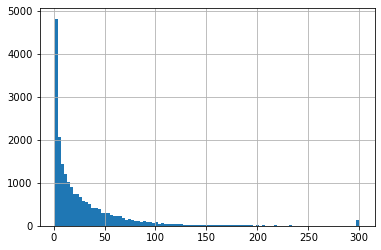

In [6]:
sex_gene_df.neg_log_p.hist(bins=100)

## Load Sex Signatures

In [7]:
gtex_seed = '451283'
gtex_k = 200
gtex_feature = "nmf_111"

In [8]:
# Load the gtex weight matrix containing the best sex feature
gtex_weight_df = (
    load_weight_matrix(dataset='GTEX',
                       z_dim=gtex_k,
                       seed=gtex_seed)
    .reset_index()
)
gtex_weight_df.gene_id = gtex_weight_df.gene_id.astype(str)

gtex_weight_df.head()

,gene_id,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,...,dae_190,dae_191,dae_192,dae_193,dae_194,dae_195,dae_196,dae_197,dae_198,dae_199
0,3043,0.004391,-0.003971,0.001468,-0.011569,0.008503,-0.004571,0.018591,-0.003835,-0.001917,...,-0.194520,0.234054,0.142296,0.045078,-0.212775,0.063615,0.050995,-0.039064,-0.016615,0.162770
1,3040,0.003391,-0.003177,0.001366,-0.009521,0.007051,-0.003626,0.015497,-0.003466,-0.001718,...,-0.175850,0.092118,-0.020116,-0.080031,-0.211380,0.015068,-0.137143,-0.123046,-0.022921,0.005490
2,6280,0.001972,-0.005423,0.007663,-0.005640,0.003097,-0.007758,0.019760,-0.003448,-0.006478,...,-0.195837,-0.071223,0.014207,-0.104960,-0.206973,0.070755,-0.002878,-0.149947,-0.190337,-0.055807
3,5644,0.003685,-0.002328,0.000388,-0.003179,0.000970,0.000403,-0.006603,0.004101,-0.003913,...,-0.108998,-0.433535,-0.111563,-0.147424,-0.131638,0.047730,0.082951,-0.171417,-0.065412,-0.057985
4,2512,-0.005885,-0.008677,-0.006711,-0.010242,0.016632,-0.020805,0.005641,-0.003083,0.007285,...,-0.104151,0.021949,0.084271,-0.003047,-0.156451,0.026323,0.059824,0.081034,-0.090100,0.011922


In [9]:
# Align the weight matrix to the Sex Gene Database
gtex_sex_feature = (
    gtex_weight_df
    .merge(gene_df,
           left_on="gene_id",
           right_on="entrez_gene_id",
           how="left")
    .loc[:, gene_df.columns.tolist() + [gtex_feature]]
    .assign(abs_value_feature = gtex_weight_df.loc[:, gtex_feature].abs().tolist())
)

gtex_sex_feature.entrez_gene_id = gtex_sex_feature.entrez_gene_id.astype(str)

gtex_sex_feature = (
    gtex_sex_feature
    .merge(sex_gene_df,
           left_on="entrez_gene_id",
           right_on="entrez_gene_id",
           how="left")
    .sort_values(by="abs_value_feature", ascending=False)
    .dropna(subset=["entrez_gene_id", "Padj"])
    .reset_index(drop=True)
)

print(gtex_sex_feature.shape)

# Show the top 10 genes
gtex_sex_feature.head(10)

(2384, 16)


,entrez_gene_id,symbol,description,chromosome,gene_type,synonyms,aliases,nmf_111,abs_value_feature,Species,Symbol,FPKM(F),FPKM(M),log2(M/F ratio),Padj,neg_log_p
0,6192,RPS4Y1,"ribosomal protein S4, Y-linked 1",Y,protein-coding,"[RPS4Y, S4]","40S ribosomal protein S4, Y isoform 1|40S ribo...",0.657703,0.657703,Human,RPS4Y1,0.169340,79.083927,8.69070,7.218300e-236,235.141565
1,8284,KDM5D,lysine demethylase 5D,Y,protein-coding,"[HY, HYA, JARID1D, SMCY]","lysine-specific demethylase 5D|H-Y|Jumonji, AT...",0.594657,0.594657,Human,KDM5D,0.023831,9.706349,8.96300,1.009195e-222,221.996025
2,8653,DDX3Y,"DEAD-box helicase 3, Y-linked",Y,protein-coding,[DBY],ATP-dependent RNA helicase DDX3Y|DEAD (Asp-Glu...,0.361573,0.361573,Human,DDX3Y,0.041641,17.594382,8.72735,1.208356e-214,213.917805
3,293,SLC25A6,solute carrier family 25 member 6,X|Y,protein-coding,"[AAC3, ANT, ANT 2, ANT 3, ANT3, ANT3Y]","ADP/ATP translocase 3|ADP,ATP carrier protein|...",0.041219,0.041219,Human,SLC25A6,342.381678,67.587137,-2.63100,5.116000e-130,129.291069
4,8742,TNFSF12,tumor necrosis factor superfamily member 12,17,protein-coding,"[APO3L, DR3LG, TNLG4A, TWEAK]",tumor necrosis factor ligand superfamily membe...,0.014331,0.014331,Human,TNFSF12,17.999314,3.677092,-2.57170,1.153900e-93,92.937832
5,6176,RPLP1,ribosomal protein lateral stalk subunit P1,15,protein-coding,"[LP1, P1, RPP1]",60S acidic ribosomal protein P1|acidic ribosom...,0.012693,0.012693,Human,RPLP1,529.542495,111.866460,-2.53800,7.844700e-159,158.105424
6,6157,RPL27A,ribosomal protein L27a,11,protein-coding,[L27A],60S ribosomal protein L27a,0.012013,0.012013,Human,RPL27A,148.518239,26.907511,-2.75820,1.302800e-122,121.885122
7,6133,RPL9,ribosomal protein L9,4,protein-coding,"[L9, NPC-A-16]",60S ribosomal protein L9,0.011588,0.011588,Human,RPL9,171.392475,24.490983,-3.09700,8.893100e-62,61.050947
8,56172,ANKH,ANKH inorganic pyrophosphate transport regulator,5,protein-coding,"[ANK, CCAL2, CMDJ, CPPDD, HANK, MANK]",progressive ankylosis protein homolog|ankylosi...,0.011298,0.011298,Human,ANKH,7.190854,1.766203,-2.32450,1.282000e-45,44.892112
9,9643,MORF4L2,mortality factor 4 like 2,X,protein-coding,"[MORFL2, MRGX]",mortality factor 4-like protein 2|MORF-related...,0.011251,0.011251,Human,MORF4L2,217.771097,59.079558,-2.19030,4.202700e-37,36.376472


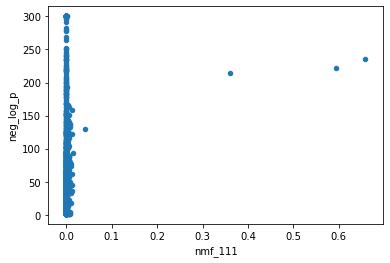

In [10]:
gtex_sex_feature.plot(kind="scatter", x=gtex_feature, y="neg_log_p")

## TCGA Sex Signature

In [11]:
tcga_seed = '165158'
tcga_k = 200
tcga_feature = "ica_151"

In [12]:
# Load the TCGA weight matrix containing the best sex feature
tcga_weight_df = (
    load_weight_matrix(dataset='TCGA',
                       z_dim=tcga_k,
                       seed=tcga_seed)
    .reset_index()
)

tcga_weight_df.gene_id = tcga_weight_df.gene_id.astype(str)
tcga_weight_df.head()

,gene_id,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,...,dae_190,dae_191,dae_192,dae_193,dae_194,dae_195,dae_196,dae_197,dae_198,dae_199
0,213,0.001632,0.009098,0.015186,-0.006079,0.024162,0.019315,-0.009256,0.010782,0.024672,...,-0.111631,-0.103814,-0.110643,-0.153390,-0.088939,-0.060406,-0.121983,-0.124331,-0.109532,-0.120856
1,7038,-0.006516,0.003712,0.006179,-0.001222,-0.017978,-0.008492,-0.000103,-0.012612,0.004762,...,-0.125725,-0.141070,-0.086306,-0.103282,-0.088973,-0.372882,-0.092755,-0.155091,-0.133590,-0.117398
2,1277,0.000600,-0.001438,-0.000483,0.005675,-0.001087,-0.002049,-0.005680,0.000143,-0.001382,...,-0.108265,-0.144565,-0.127301,-0.172421,-0.079622,-0.066244,-0.109065,-0.180018,-0.151157,-0.172270
3,2335,-0.004013,-0.001402,0.007743,0.011443,-0.005816,-0.004384,-0.013617,-0.005412,0.001746,...,-0.167084,-0.123665,-0.120929,-0.194044,0.101971,0.146615,-0.148788,-0.207472,-0.169713,-0.153405
4,3852,0.011302,-0.015284,-0.006901,0.024058,0.018579,-0.030537,-0.010623,-0.001460,0.035389,...,-0.137463,-0.148097,-0.115936,-0.182955,-0.028604,0.151482,-0.120763,-0.147112,-0.172387,-0.134200


In [13]:
# Align the weight matrix to the Sex Gene Database
tcga_sex_feature = (
    tcga_weight_df
    .merge(gene_df,
           left_on="gene_id",
           right_on="entrez_gene_id",
           how="left")
    .loc[:, gene_df.columns.tolist() + [tcga_feature]]
    .assign(abs_value_feature = tcga_weight_df.loc[:, tcga_feature].abs().tolist())
)

tcga_sex_feature.entrez_gene_id = tcga_sex_feature.entrez_gene_id.astype(str)

tcga_sex_feature = (
    tcga_sex_feature
    .merge(sex_gene_df,
           left_on="entrez_gene_id",
           right_on="entrez_gene_id",
           how="left")
    .sort_values(by="abs_value_feature", ascending=False)
    .dropna(subset=["entrez_gene_id", "Padj"])
    .reset_index(drop=True)
)

print(tcga_sex_feature.shape)
tcga_sex_feature.head(20)

(2213, 16)


,entrez_gene_id,symbol,description,chromosome,gene_type,synonyms,aliases,ica_151,abs_value_feature,Species,Symbol,FPKM(F),FPKM(M),log2(M/F ratio),Padj,neg_log_p
0,8273,SLC10A3,solute carrier family 10 member 3,X,protein-coding,"[DXS253E, P3]",P3 protein|Protein P3|solute carrier family 10...,-0.007441,0.007441,Human,SLC10A3,28.580859,8.038733,-2.15080,1.373900e-22,21.862045
1,60343,FAM3A,family with sequence similarity 3 member A,X,protein-coding,"[2.19, DLD, DXS560S, XAP-7]",protein FAM3A|cytokine-like protein 2-19,-0.007233,0.007233,Human,FAM3A,19.683939,5.818768,-2.05170,1.912500e-47,46.718399
2,10735,STAG2,stromal antigen 2,X,protein-coding,"[SA-2, SA2, SCC3B, bA517O1.1]",cohesin subunit SA-2|SCC3 homolog 2,-0.007162,0.007162,Human,STAG2,13.465725,3.360696,-2.29560,1.147500e-65,64.940247
3,29978,UBQLN2,ubiquilin 2,X,protein-coding,"[ALS15, CHAP1, DSK2, HRIHFB2157, N4BP4, PLIC2]",ubiquilin-2|Nedd4 binding protein 4|protein li...,0.005195,0.005195,Human,UBQLN2,13.149286,3.683552,-2.12710,5.137800e-51,50.289223
4,5355,PLP2,proteolipid protein 2,X,protein-coding,"[A4, A4LSB]",proteolipid protein 2|A4 differentiation-depen...,0.004974,0.004974,Human,PLP2,82.385729,22.696051,-2.19620,4.574400e-28,27.339666
5,27316,RBMX,"RNA binding motif protein, X-linked",X,protein-coding,"[HNRNPG, HNRPG, MRXS11, RBMXP1, RBMXRT, RNMX, ...","RNA-binding motif protein, X chromosome|glycop...",-0.004445,0.004445,Human,RBMX,66.083914,16.138551,-2.31330,2.284100e-74,73.641285
6,55558,PLXNA3,plexin A3,X,protein-coding,"[6.3, HSSEXGENE, PLXN3, PLXN4, XAP-6]",plexin-A3|Sex chromosome X transmembrane prote...,-0.004327,0.004327,Human,PLXNA3,18.892544,5.445406,-2.08760,1.046900e-27,26.980095
7,1968,EIF2S3,eukaryotic translation initiation factor 2 sub...,X,protein-coding,"[EIF2, EIF2G, EIF2gamma, eIF-2gA]",eukaryotic translation initiation factor 2 sub...,0.004283,0.004283,Human,EIF2S3,73.459065,13.756572,-2.70230,1.030900e-91,90.986783
8,2000,ELF4,E74 like ETS transcription factor 4,X,protein-coding,"[ELFR, MEF]",ETS-related transcription factor Elf-4|E74-lik...,-0.003768,0.003768,Human,ELF4,9.815378,2.421990,-2.28990,3.936700e-68,67.404868
9,92745,SLC38A5,solute carrier family 38 member 5,X,protein-coding,"[JM24, SN2, SNAT5, pp7194]",sodium-coupled neutral amino acid transporter ...,0.003665,0.003665,Human,SLC38A5,4.772165,45.647243,0.62100,2.914350e-27,26.535458


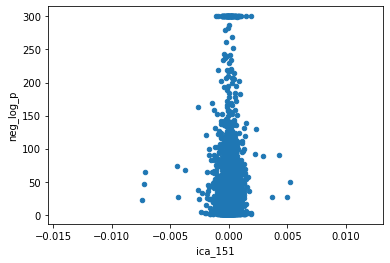

In [14]:
tcga_sex_feature.plot(kind="scatter", x=tcga_feature, y="neg_log_p")